Total .jpg files found: 25331
Sample image names: ['ISIC_0057312.jpg', 'ISIC_0014233_downsampled.jpg', 'ISIC_0059626.jpg', 'ISIC_0056156.jpg', 'ISIC_0030912.jpg']


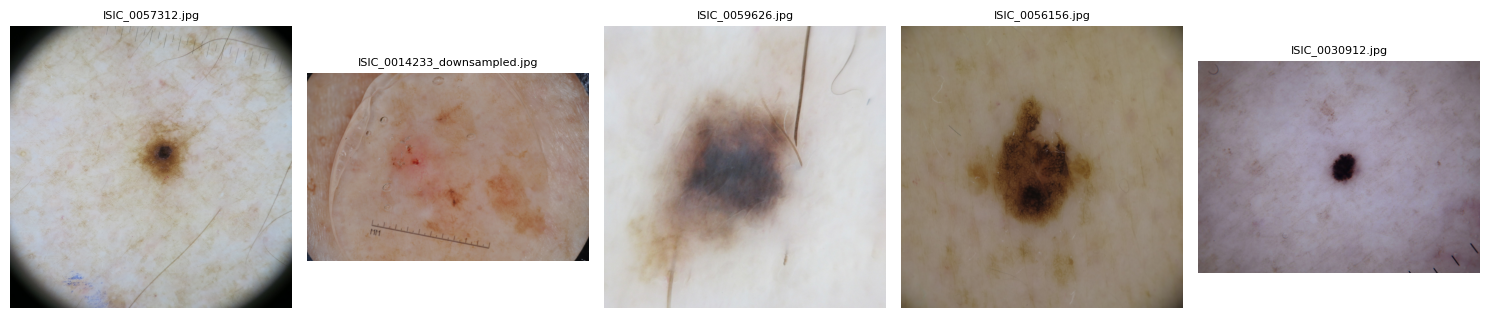


Training labels preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Melanoma images: 4522
Non-Melanoma images: 20809

MEL column class distribution (%):
MEL
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64
Applying filters to all images...


100%|██████████| 25331/25331 [3:27:15<00:00,  2.04it/s]


Completed
Filtered images: ['ISIC_0024608.png', 'ISIC_0068491.png', 'ISIC_0055836.png', 'ISIC_0061880.png', 'ISIC_0071807.png', 'ISIC_0057394.png', 'ISIC_0025782.png', 'ISIC_0062511.png', 'ISIC_0014818_downsampled.png', 'ISIC_0025526.png']
Augmented images: ['ISIC_0027065_aug3.png', 'ISIC_0024958_aug2.png', 'ISIC_0058947_aug4.png', 'ISIC_0014291_downsampled_aug1.png', 'ISIC_0013995_downsampled_aug1.png', 'ISIC_0054673_aug4.png', 'ISIC_0062686_aug4.png', 'ISIC_0061880.png', 'ISIC_0057787_aug4.png', 'ISIC_0000142_downsampled_aug1.png']


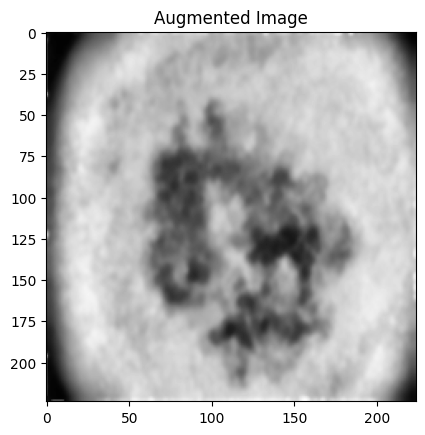

In [1]:
# === Imports ===
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm

# === Path Setup ===
# Paths to the dataset inside Kaggle
base_path = '/kaggle/input/isic-2019'
image_folder = os.path.join(base_path, 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input')
labels_path = os.path.join(base_path, 'ISIC_2019_Training_GroundTruth.csv')

# === Check Images ===
# List only .jpg image files (ignore folders)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(image_folder, f))]

print("Total .jpg files found:", len(image_files))
print("Sample image names:", image_files[:5])

# === Visualize First 5 Images ===
plt.figure(figsize=(15, 5))
for i, image_file in enumerate(image_files[:5]):
    image_path = os.path.join(image_folder, image_file)
    img = mpimg.imread(image_path)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(image_file, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# === Load Labels CSV ===
df = pd.read_csv(labels_path)
print("\nTraining labels preview:")
print(df.head())

# === 6. Melanoma vs. Non-Melanoma ===
# Count number of melanoma vs non-melanoma
melanoma_count = df[df["MEL"] == 1].shape[0]
non_melanoma_count = df[df["MEL"] == 0].shape[0]

print(f"\nMelanoma images: {melanoma_count}")
print(f"Non-Melanoma images: {non_melanoma_count}")

# Percent distribution
print("\nMEL column class distribution (%):")
print(df["MEL"].value_counts(normalize=True) * 100)

# Output Folder (Kagggle)
filtered_output_folder = './filtered_images'
os.makedirs(filtered_output_folder, exist_ok=True)

df_filtered = df[["image", "MEL"]]

# === Filtering ===
def apply_filters(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
   # Convert to grayscale once
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Hair removal
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    blackhat_blur = cv2.GaussianBlur(blackhat, (9, 9), cv2.BORDER_REPLICATE)
    _, mask = cv2.threshold(blackhat_blur, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inpainted_bgr = cv2.inpaint(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), mask, 4, cv2.INPAINT_TELEA)
    inpainted_gray = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2GRAY)

    # blue
    denoised = cv2.medianBlur(inpainted_gray, 5)
    denoised = cv2.bilateralFilter(denoised, d=17, sigmaColor=100, sigmaSpace=100)

    # Contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final = clahe.apply(denoised)

    # Resize
    resized = cv2.resize(final, (224, 224), interpolation=cv2.INTER_AREA)
    return resized
    
print("Applying filters to all images...")

processed_images = []
skipped_images = []

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    image_id = row["image"]
    mel_label = row["MEL"]
    image_path = os.path.join(image_folder, image_id + ".jpg")

    filtered_img = apply_filters(image_path)
    if filtered_img is not None:
        output_path = os.path.join(filtered_output_folder, image_id + ".png")
        cv2.imwrite(output_path, filtered_img)
        processed_images.append((image_id, mel_label))

# === Data Augmentation for Melanoma Images ===

augmented_output_folder = "./augmented_images"
os.makedirs(augmented_output_folder, exist_ok=True)

augmented_records = []

# Select Melanoma only from df_filtered
mel_df = df_filtered[df_filtered["MEL"] == 1]

def rotate_image(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Calculate new bounding box dimensions
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)

    # Adjust the matrix to the center
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    return cv2.warpAffine(img, M, (new_w, new_h))

# Augmentation function
def augment_image(img):
    aug_images = []

    # Horizontal flip
    aug_images.append(cv2.flip(img, 1))

    # Rotation
    for angle in [15, -15]:
        aug_images.append(rotate_image(img, angle))

    # Gaussian Noise
    noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    aug_images.append(noisy_img)

    # Brightness Adjustment
    bright_img = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    aug_images.append(bright_img)

    return aug_images

# Apply augmentation
for idx, row in mel_df.iterrows():
    img_id = row["image"]
    label = row["MEL"]
    img_path = os.path.join(filtered_output_folder, img_id + ".png")

    if not os.path.isfile(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Save original
    new_name = f"{img_id}.png"
    cv2.imwrite(os.path.join(augmented_output_folder, new_name), img)
    augmented_records.append((new_name, label))

    # Augmented versions
    aug_images = augment_image(img)
    for i, aug in enumerate(aug_images):
        aug_name = f"{img_id}_aug{i}.png"
        cv2.imwrite(os.path.join(augmented_output_folder, aug_name), aug)
        augmented_records.append((aug_name, label))

# Save new labels CSV
augmented_df = pd.DataFrame(augmented_records, columns=["image", "MEL"])
augmented_df.to_csv("./augmented_labels.csv", index=False)


print("Completed")
print("Filtered images:", os.listdir('./filtered_images')[:10])
print("Augmented images:", os.listdir('./augmented_images')[:10])
img_path = './augmented_images/ISIC_0000002.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Augmented Image')
plt.show()
